# fiTQun Regression Results Analysis
Ashley Ferreira


December 13, 2023


In [19]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
import WatChMaL.analysis.utils.fitqun as fq
plt.style.use('ggplot')
from scipy.optimize import curve_fit

def gaussian(x, a, mean, sigma):
    result = a * np.exp(-((x - mean)**2 / (2 * sigma**2)))
    #print(result)
    return result


def regression_analysis(true_positions, pred_positions):
    '''
    Plot the regression results in two main ways:
    1. predicted vs true value
    2. rediduals histogram

    Args:
        ture_positions (array): 1D array of true position values for each event.
        pred_positions (array): 1D array of position values predicted by model for each event.   

    Returns:
        None
    '''
    # loop over x, y, and x axis
    vertex_axis = ['X', 'Y', 'Z']
    for i in range(3): 

        ##################################
        #### predicted vs true values ####
        ##################################

        # initialize figure and plot pred_positions versus true_positions
        plt.figure(figsize=(5,5))
        color = plt.rcParams["axes.prop_cycle"].by_key()["color"][i]
        plt.scatter(true_positions[:,i], pred_positions[:,i], alpha=0.1, s=0.1, color=color, label='event')

        # generate "compolete agreement" like pred_positons = true_positions
        line = np.linspace(-1600,1600,2000)
        x = line
        plt.plot(line, line, '--', color='black', alpha=0.5, label='complete agreement')

        # there may be a couple stray values so set x and y axis limits
        plt.xlim(-2000,2000)
        plt.ylim(-2000,2000)
        
        # format the plot labels and all
        plt.title(f'Event Vertex for {vertex_axis[i]} Axis')
        plt.xlabel('True Position [cm]')
        plt.ylabel('Predicted Position [cm]')
        plt.legend()
        plt.show()

        ##################################
        ####        rediduals         ####
        ##################################

        # calculate residuals 
        residuals = true_positions[:,i] - pred_positions[:,i]

        # again, there are some stray values so to not mess
        # with the binning too much we apply a cut at a certain
        # +/- value from zero, in this case I do 1600 cm
        cut = 1600
        residuals_cut = [] 
        for r in range(len(residuals)):
            if -cut < residuals[r] <  cut:
                residuals_cut.append(residuals[r])

        yhist, xhist, _ = plt.hist(residuals_cut, bins=100, alpha=0.7, color=color, label='bins=100')
        popt, pcov = curve_fit(gaussian, (xhist[1:]+xhist[:-1])/2, yhist, bounds=(-np.inf, np.inf), p0=[40, 0, 70])    # what is this p0?
        perr = np.sqrt(np.diag(pcov))

        plt.plot(x, gaussian(x, *popt), alpha=1, color='black', label='guassian fit') # why is this not showing a fit?

        # mean and std can be calculated directly
        # error on bins, need to give one to curve_fit --> but bins that are higher should constribute more
        # sqrt of count in bins

        # round numbers
        mu = round(popt[1], 2)
        mu_uncert = round(perr[1], 2)
        std = round(popt[2], 2)*-1 # this neg 1 is probs the issue?
        std_uncert = round(perr[2], 2)

        plt.text(0.08, 0.82, '$\mu$ = {} $\pm$ {} [cm] \n\n$\sigma$ = {} $\pm$ {} [cm]'.format(mu, mu_uncert, np.abs(std), std_uncert), fontsize=10, transform = plt.gca().transAxes, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))

        plt.xlim(-cut, cut)

        plt.title(f'Event Vertex for {vertex_axis[i]} Axis')
        plt.xlabel('true - predicted [cm]')
        plt.ylabel('count')
        plt.legend()
        plt.show()


def un_normalize(data, norm_min=-1, x_bounds=(-1600,1600), y_bounds=(-1600,1600), z_bounds=(-1600,1600)):
    '''
    Assume data has been normalized to a range of [-1, 1] or [0, 1]
    this function brings the values back to their original values 

    Args:
        data (array): 1D array of data to be unnormalized.
        norm_min (int, optional): minimum of normalized data. can only be -1 or 0. 
        x_bounds (tuple, optional): real minimum and maximum value of original data on x-axis.s
        y_bounds (tuple, optional): real minimum and maximum value of original data on y-axis.
        z_bounds (tuple, optional): real minimum and maximum value of original data on z-axis.

    Returns:
        data (np.array): unnormalized data.
    '''
    bounds = [x_bounds, y_bounds, z_bounds]
    for i in range(3):

        if norm_min == 0:
            data[i] = ((data[i])*(bounds[i][1] - bounds[i][0])) + bounds[i][0] 

        elif norm_min == -1: 
            data[i] = data[i]*(bounds[i][1])
        
    return data

def fitqun_regression_results(hy_path = '/fast_scratch_2/aferreira/t2k/ml/data/oct20_combine_flatE/', 
                              npy_path = '/fast_scratch_2/aferreira/t2k/ml/data/oct20_combine_flatE/nov29_normed_regression_shared/20092023-101855/'):
    '''
    Plot fiTQun specific regression results using un_normalize(), regression_analysis(), and read_fitqun_file().

    Args:
        hy_path (str, optional): directory where fitqun_combine.hy and combine_combine.hy files are located. 
        true_path (str, optional): directory where true_positions.npy file is located.

    Returns:
        None
    '''
    # get values out of fitqun file, where mu_1rpos and e_1rpos are the positions of muons and electrons respectively
    (_, labels, _, fitqun_hash), (mu_1rpos, e_1rpos) = fq.read_fitqun_file(hy_path+'fitqun_combine.hy', regression=True)

    print('original mu_1rpos.shape =', mu_1rpos.shape)
    print('original e_1rpos.shape =', e_1rpos.shape)
    #mu_1rpos = np.reshape(mu_1rpos,(int(mu_1rpos.shape[0]/3), 3))
    #e_1rpos = np.reshape(e_1rpos,(int(e_1rpos.shape[0]/3), 3))

    # read in the indices file
    idx = np.array(sorted(np.load(npy_path + "/indices.npy")))

    #softmax = np.array(np.load(str(newest_directory) + "/softmax.npy"))




    # read in the main HDF5 file that has the rootfiles and event_ids
    hy = h5py.File(hy_path+'combine_combine.hy', "r")
    #rootfiles = np.array(hy['root_files'])[idx].squeeze() 
    #event_ids = np.array(hy['event_ids'])[idx].squeeze()

    angles = np.array(hy['angles'])[idx].squeeze() 
    #labels = np.array(hy['labels'])[idx].squeeze() 
    veto = np.array(hy['veto'])[idx].squeeze()
    energies = np.array(hy['energies'])[idx].squeeze()
    positions = np.array(hy['positions'])[idx].squeeze()
    #directions = math.direction_from_angles(angles)
    rootfiles = np.array(hy['root_files'])[idx].squeeze()
    event_ids = np.array(hy['event_ids'])[idx].squeeze()
    ml_hash = fq.get_rootfile_eventid_hash(rootfiles, event_ids, fitqun=False)

    print('LEN1 :', positions.shape)
    print('LEN2 :', mu_1rpos.shape)
    
    # get the eventid hash for the machine learning events
    #ml_hash = fq.get_rootfile_eventid_hash(rootfiles, event_ids, fitqun=False) 

    # load in the true positions 
    true_positions = np.load(npy_path + "true_positions.npy")
    print('true_positions.shape =', true_positions.shape)
    
    # unnormalize the true_positions
    tp = []
    for t in true_positions:
        tp.append(un_normalize(t))
    true_positions = np.array(tp)

    print('true_positions =', true_positions)
    print('mu_1rpos =', mu_1rpos)
    print('e_1rpos =', e_1rpos)

    # use intersect1d to find the intersection of fitqun_hash and ml_hash, specifically, intersect is a 
    # sorted 1D array of common and unique elements, comm1 is the indices of the first occurrences of 
    # the common values in fitqun_hash, comm2 is the indices of the first occurrences of the common values 
    # in ml_hash. So we use comm1 to index fitqun_hash and comm2 to index ml_hash.
    intersect, comm1, comm2 = np.intersect1d(fitqun_hash, ml_hash, assume_unique=True, return_indices=True)
    print(f'intersect: {intersect}, comm1: {comm1}, comm2: {comm2}')
    fitqun_labels = labels[comm1]
    fitqun_mu_1rpos = mu_1rpos[comm1].squeeze() 
    fitqun_e_1rpos = e_1rpos[comm1].squeeze() 
    #fitqun_true_positions = true_positions[comm2] 
    positions = positions[comm2]

    #print(len(positions))

    # now we want to look over both labels, 0 and 1, seperately... 

    # found in plotting.py :
    #  set class labels and decrease values within labels to match either 0 or 1 
    #    e_label = [1]
    #    mu_label = [0]
    #  so I have been assuming label 0 = muons and label 1 = electrons

    # (i have tried both ways incase this understanding of our labels was wrong)

    # loop over each event and check if it is a muon or electon 
    # event then save to their individual lists
    true_0, pred_0 = [], []
    true_1, pred_1 = [], []
    for i in range(len(fitqun_labels)):
        # LABEL 0 - muons  
        if fitqun_labels[i] == 0:
            true_0.append(positions[i])
            pred_0.append(fitqun_mu_1rpos[i])

        # LABEL 1 - electrons  
        else:
            true_1.append(positions[i])
            pred_1.append(fitqun_e_1rpos[i])

    # convert lists to arrayss
    true_0 = np.array(true_0)
    true_1 = np.array(true_1)
    pred_0 = np.array(pred_0)
    pred_1 = np.array(pred_1)

    plt.clf()
    '''
    plt.hist(true_0[:,0], bins='auto', label='x-axis', alpha=0.5)
    plt.hist(true_0[:,1], bins='auto', label='y-axis', alpha=0.5)
    plt.hist(true_0[:,2], bins='auto', label='z-axis', alpha=0.5)
    plt.ylabel('position')
    plt.xlabel('count')
    plt.title('fitqun positions - MUONS')
    plt.legend()
    plt.show()

    plt.hist(true_1[:,0], bins='auto', label='x-axis', alpha=0.5)
    plt.hist(true_1[:,1], bins='auto', label='y-axis', alpha=0.5)
    plt.hist(true_1[:,2], bins='auto', label='z-axis', alpha=0.5)
    plt.ylabel('position')
    plt.xlabel('count')
    plt.title('fitqun positions - ELECTRONS')
    plt.legend()
    plt.show()
    '''
    print('######## MUON EVENTS ########')
    regression_analysis(true_0, pred_0)

    print('######## ELECTRON EVENTS ########')
    regression_analysis(true_1, pred_1)

<KeysViewHDF5 ['e_1rdir', 'e_1rmom', 'e_1rnll', 'e_1rpos', 'event_ids', 'labels', 'mu_1rdir', 'mu_1rmom', 'mu_1rnll', 'mu_1rpos', 'pi_1rdir', 'pi_1rmom', 'pi_1rnll', 'pi_1rpos', 'root_files']>
[  0   1   2 ... 197 198 199]
[  0   1   2 ... 197 198 199]
fitqun e- avg: 0.9799709117915552
fitqun mu- avg: 0.9286346396965866
(240002, 1, 3) (240002, 1, 3)
original mu_1rpos.shape = (240002, 1, 3)
original e_1rpos.shape = (240002, 1, 3)
[  0   1   2 ...  25  87 105]
[  1   2   3 ...  26  88 106]
LEN1 : (231085, 3)
LEN2 : (240002, 1, 3)
true_positions.shape = (231085, 3)
true_positions = [[ -373.04007  -240.96448  -800.8162 ]
 [-1198.3689    349.7857   -977.7894 ]
 [  399.5152  -1562.0879  -1691.8887 ]
 ...
 [  389.138    -643.3491   -174.72229]
 [ -146.5997  -1572.5122   -959.68964]
 [-1205.9081    487.63663   546.2595 ]]
mu_1rpos = [[[ 1240.3596    -599.1086    1191.5516  ]]

 [[-1168.0685     850.14734    -46.152973]]

 [[  496.03055   1024.9705     781.83417 ]]

 ...

 [[-1270.8397    -367.

<Figure size 640x480 with 0 Axes>

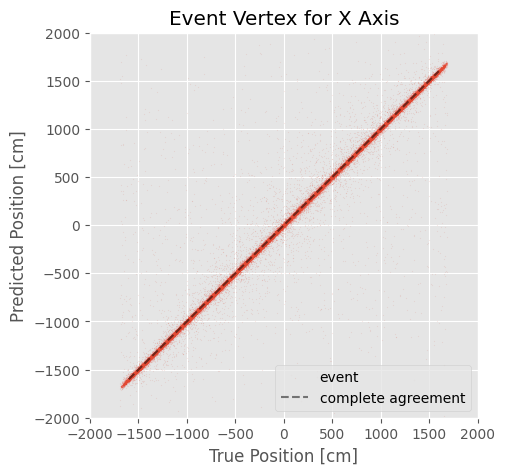

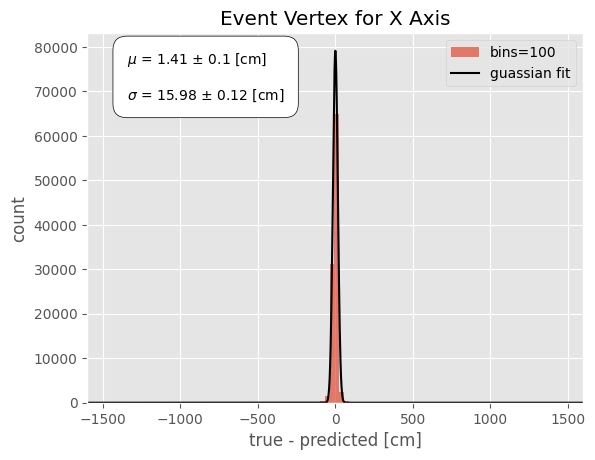

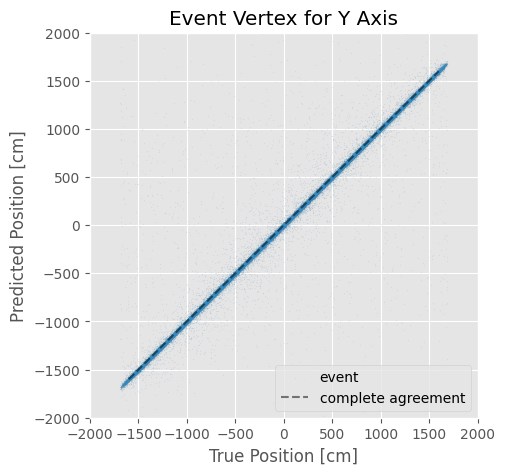

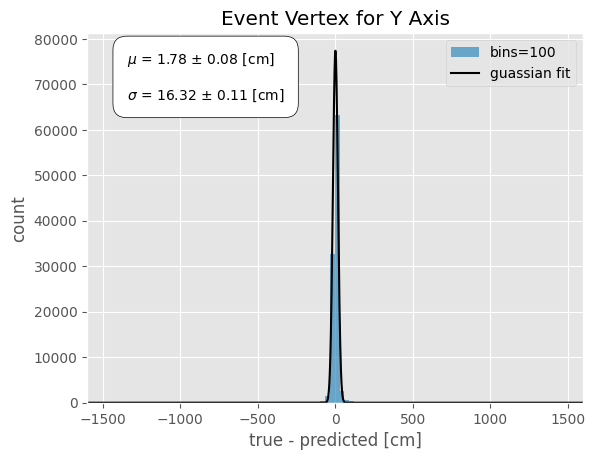

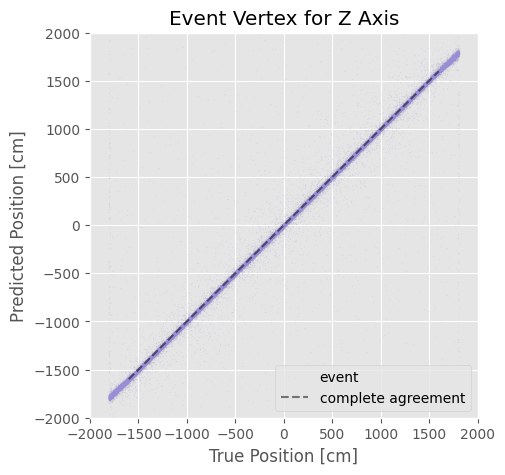

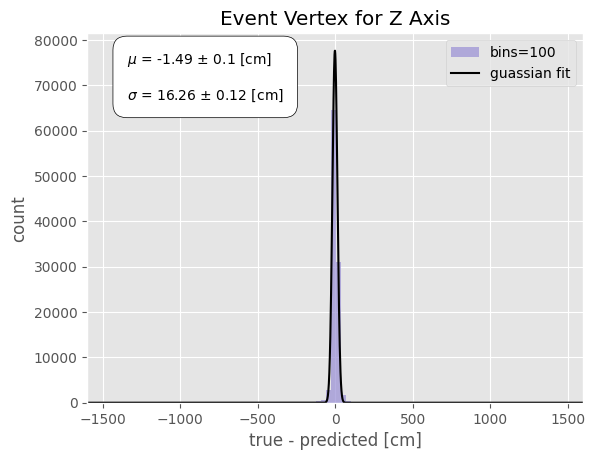

######## ELECTRON EVENTS ########


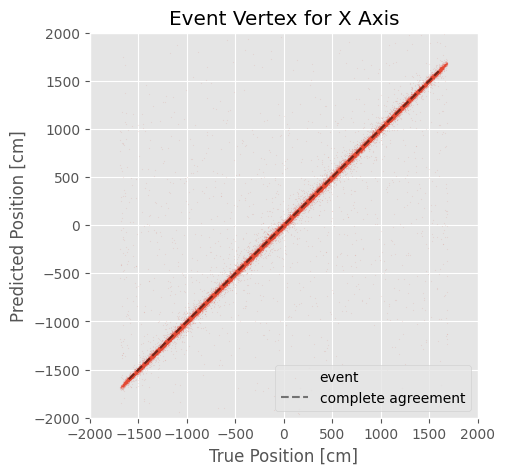

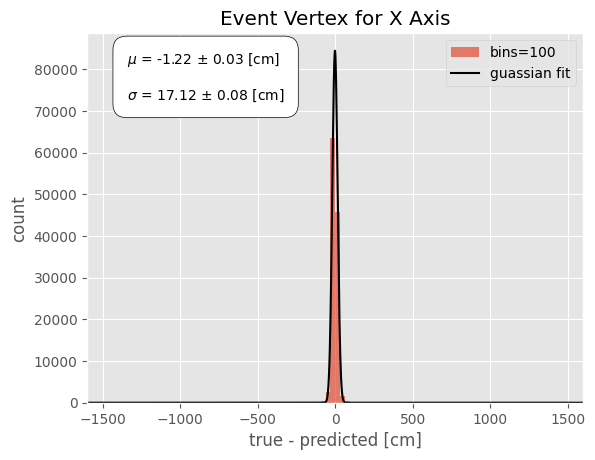

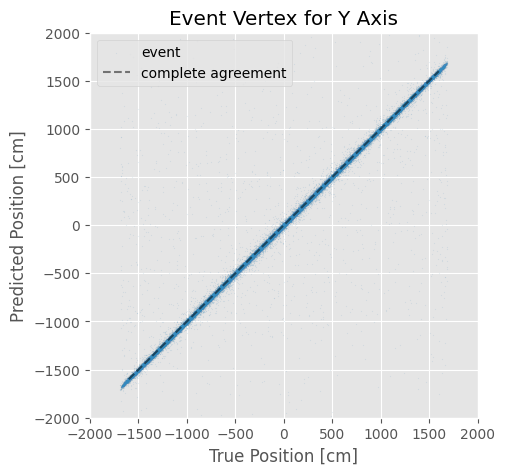

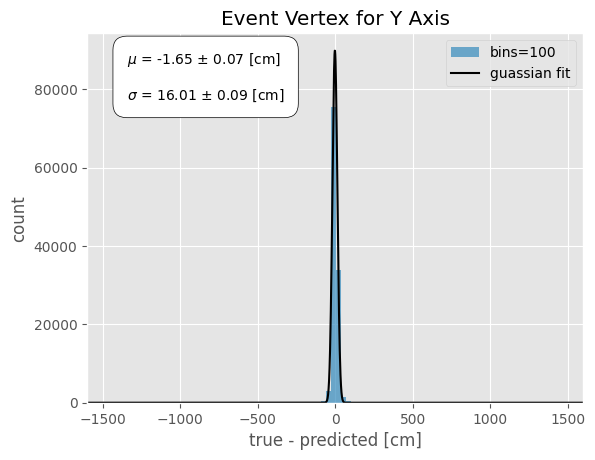

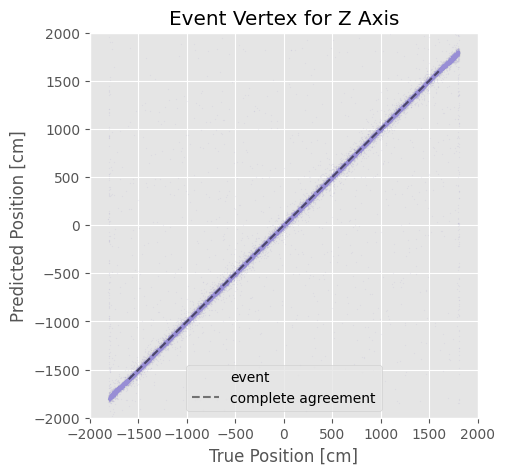

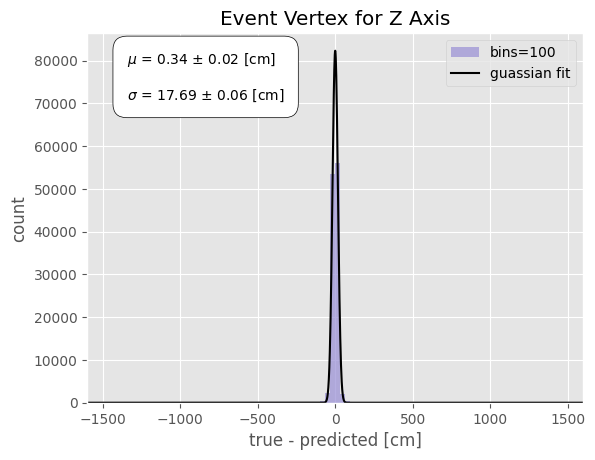

In [20]:
fitqun_regression_results() # mapping between them must not be correct to get this absolute random outcome

# maybe unnormalize method is wrong? normlize both?
# felix was grabbing positions from combine_combine.hy file --> efficiency_plots